<a href="https://colab.research.google.com/github/mobarakol/computer_vision_tutorial/blob/main/3D_reconstruction_depth_pose_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (89/89), done.


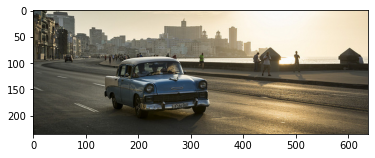

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open("/content/monodepth2/assets/test_image.jpg"))

/content/monodepth2
-> Downloading pretrained model to models/mono+stereo_640x192.zip
   Unzipping model...
   Model unzipped to models/mono+stereo_640x192
-> Loading model from  models/mono+stereo_640x192
   Loading pretrained encoder
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved predictions to:
   - assets/test_image_disp.jpeg
   - assets/test_image_disp.npy
-> Done!
/content


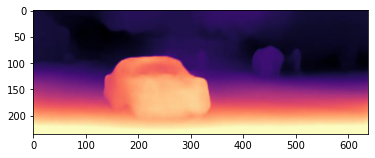

(<matplotlib.image.AxesImage at 0x7f9bb42f97f0>, None)

In [ ]:
%cd monodepth2
!python test_simple.py --image_path assets/test_image.jpg --model_name mono+stereo_640x192
%cd ..
plt.imshow(Image.open("/content/monodepth2/assets/test_image_disp.jpeg")), plt.show()

In [ ]:
!pip -q install open3d
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# rgbd
disp = np.array(Image.open("/content/monodepth2/assets/test_image_disp.jpeg"))
img = np.array(Image.open("/content/monodepth2/assets/test_image.jpg"))
depth_o3d = o3d.geometry.Image(disp)
image_o3d = o3d.geometry.Image(img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(disp.shape[0])
w = int(disp.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)#500, 500, 640,512
# camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))  
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) 

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box() 
mesh_crop = mesh.crop(bbox)
mesh_crop = o3d.geometry.TriangleMesh.compute_triangle_normals (mesh_crop)
img_path = "pcd" # 'monodepth2/assets/pcd'
gltf_path = f'./{img_path}.gltf'
stl_path = f'./{img_path}.stl'
o3d.io.write_triangle_mesh("pcd.gltf", mesh_crop, write_triangle_uvs=True)
o3d.io.write_triangle_mesh("pcd.stl", mesh_crop, write_triangle_uvs=True) #ply/stl/obj/off/gltf
mesh = o3d.io.read_triangle_mesh('/content/pcd.stl')
print(mesh)
# o3d.visualization.draw_geometries([mesh_crop])

from google.colab import files

files.download('/content/pcd.stl')
files.download('/content/pcd.gltf')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
intrinsic:
 [[500.    0.  319. ]
 [  0.  500.  117.5]
 [  0.    0.    1. ]]
[Open3D DEBUG] Input Points / Samples: 149888 / 72898
[Open3D DEBUG] #   Got kernel density: 0.0634441 (s), 340.219 (MB) / 340.219 (MB) / 340 (MB)
[Open3D DEBUG] #     Got normal field: 0.231341 (s), 377.258 (MB) / 377.258 (MB) / 377 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 4.019945e-06 / 6.025416e-01
[Open3D DEBUG] #       Finalized tree: 0.314002 (s), 429.336 (MB) / 429.336 (MB) / 429 (MB)
[Open3D DEBUG] #  Set FEM constraints: 1.52967 (s), 412.219 (MB) / 429.336 (MB) / 429 (MB)
[Open3D DEBUG] #Set point constraints: 0.131567 (s), 412.219 (MB) / 429.336 (MB) / 429 (MB)
[Open3D DEBUG] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip -q install numpy-stl

In [ ]:
!mkdir images

<ipython-input-11-7d5967275589>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


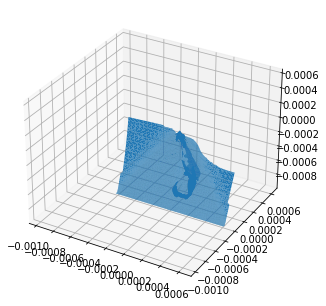

In [ ]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
mesh = mesh.Mesh.from_file('pcd.stl') # Mesh with 77255 items
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh.vectors))

# Auto scale to the mesh size
points = mesh.points #ndarray with shape (77255, 9)
scale = mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
plt.show()